# Image segmentation using Structural Analysis and Shape Descriptors (conected components with stats - canny cv)

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Automatic brightness and contrast optimization with optional histogram clipping
# from https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape/56910532
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


In [10]:
# Load image, grayscale, Gaussian Blur, Otsu's threshold
image = cv2.imread("./Potatostarch10xbrightfield.jpg",cv2.IMREAD_COLOR)
gauss = cv2.GaussianBlur(image, (5, 5), 0)
auto, alpha, beta = automatic_brightness_and_contrast(gauss)
gray = cv2.cvtColor(auto, cv2.COLOR_BGR2GRAY)
blurbf = cv2.bilateralFilter(gray,5,50,150)
thresh = cv2.threshold(blurbf, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

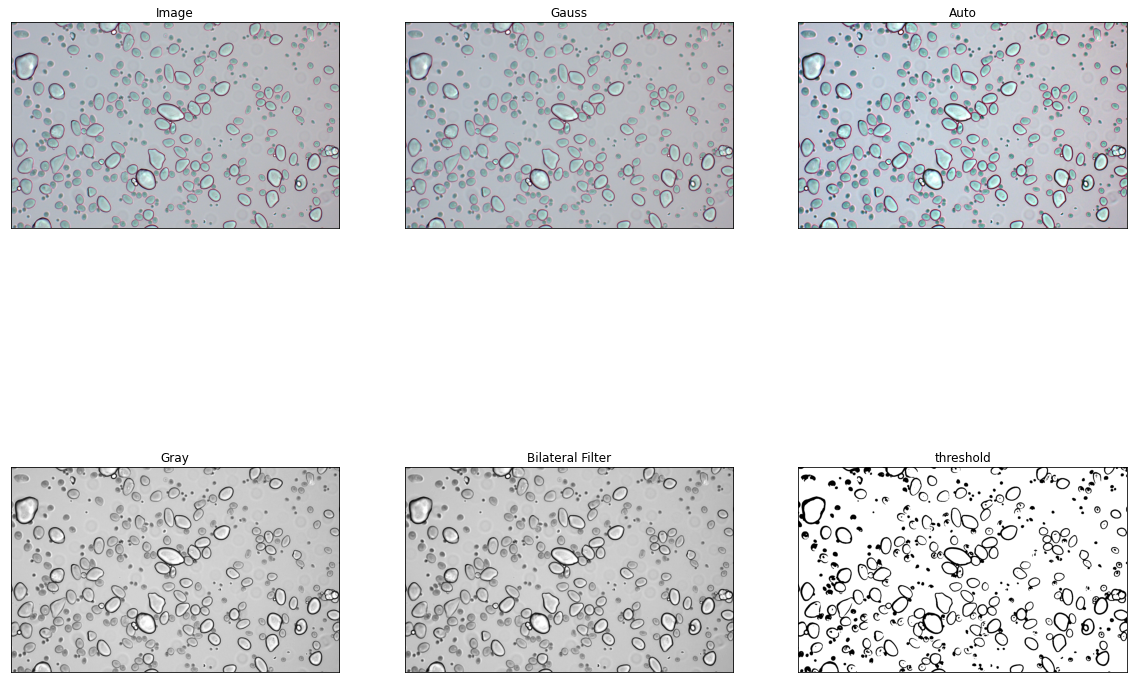

In [11]:
plt.figure(figsize = (20,15))
plt.subplot(231),plt.imshow(image),plt.title('Image')
plt.xticks([]), plt.yticks([])
plt.subplot(232),plt.imshow(gauss),plt.title('Gauss')
plt.xticks([]), plt.yticks([])
plt.subplot(233),plt.imshow(auto),plt.title('Auto')
plt.xticks([]), plt.yticks([])
plt.subplot(234),plt.imshow(gray, cmap = 'gray'),plt.title('Gray')
plt.xticks([]), plt.yticks([])
plt.subplot(235),plt.imshow(blurbf, cmap = 'gray'),plt.title('Bilateral Filter')
plt.xticks([]), plt.yticks([])
plt.subplot(236),plt.imshow(thresh, cmap = 'gray'),plt.title('threshold')
plt.xticks([]), plt.yticks([])
plt.show()

In [20]:
kernel = np.ones((3,3),np.uint8)
thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations =3)

# Perform connected component labeling
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

# Create false color image and color background black
colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # for cosmetic reason we want the background black
false_colors = colors[labels]

# Obtain centroids
false_colors_centroid = false_colors.copy()
for centroid in centroids:
    cv2.drawMarker(false_colors_centroid, (int(centroid[0]), int(centroid[1])),
                   color=(255, 255, 255), markerType=cv2.MARKER_CROSS)

# Only keep larger objects by filtering using area
MIN_AREA = 200
false_color_centroid_filter = false_colors.copy()
for i, centroid in enumerate(centroids[1:], start=1):
    area = stats[i, 4]
    if area > MIN_AREA:
        cv2.drawMarker(false_color_centroid_filter, (int(centroid[0]), int(centroid[1])),
                       color=(255, 255, 255), markerType=cv2.MARKER_CROSS)


        

# Thresholded sample image

(<matplotlib.image.AxesImage at 0x7fbdea2265d0>, Text(0.5, 1.0, 'Thresh'))

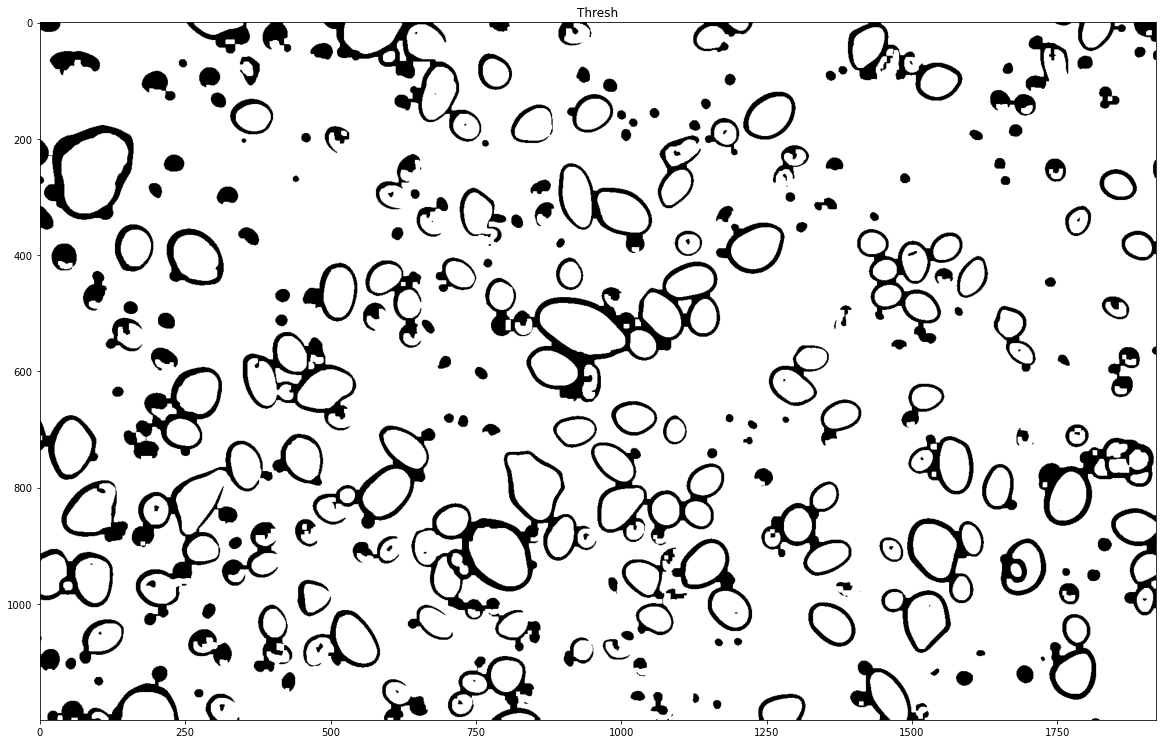

In [21]:
plt.figure(figsize = (20,14))
plt.imshow(thresh,cmap = 'gray'),plt.title('Thresh')


# 

(<matplotlib.image.AxesImage at 0x7fbdea105a50>,
 Text(0.5, 1.0, 'False Colors'))

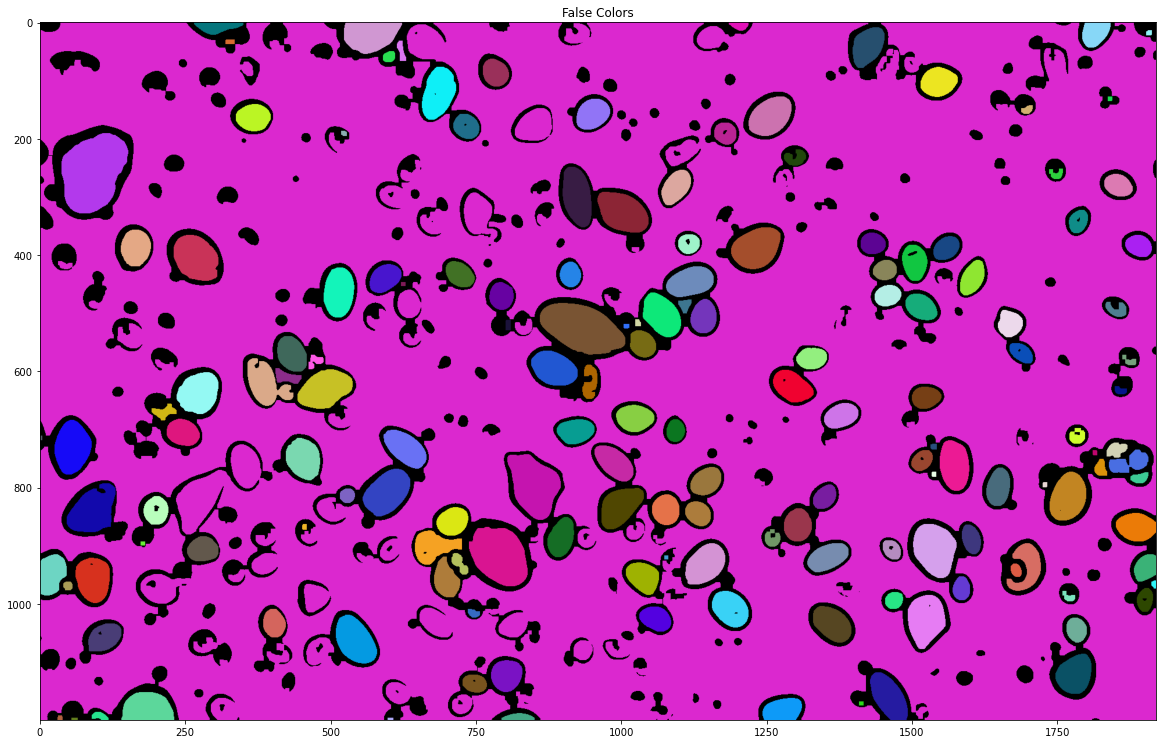

In [25]:
plt.figure(figsize = (20,14))
plt.imshow(false_colors,cmap = 'gray'),plt.title('False Colors')

(<matplotlib.image.AxesImage at 0x7fbdea0bb390>,
 Text(0.5, 1.0, 'False colors with centroids'))

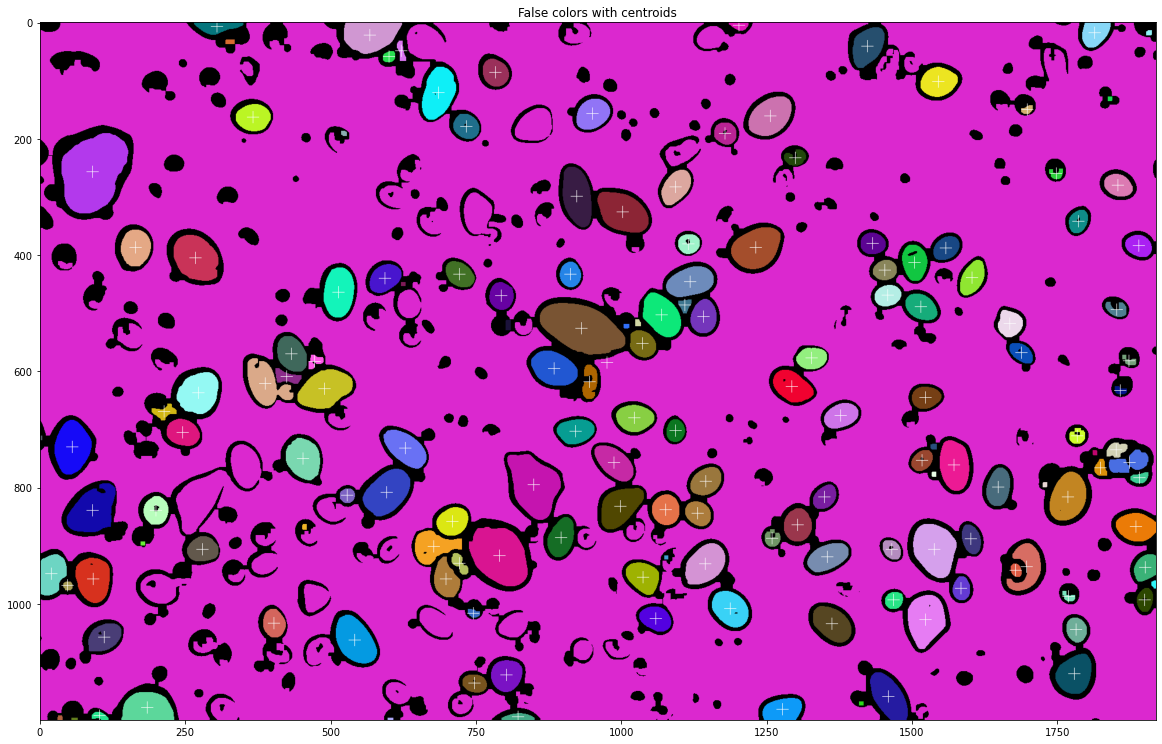

In [24]:
plt.figure(figsize = (20,14))
plt.imshow(false_color_centroid_filter,cmap = 'gray'),plt.title('False colors with centroids')